# Shift Invariance Can Reduce Adversarial Robustness

### Links:
Paper: -  [Paper online](https://papertohtml.org/paper?id=3e99fc536268dbb83bca5466f5e3f1a65f52272f)
Code: - [Data sets and code link](https://paperswithcode.com/paper/shift-invariance-can-reduce-adversarial)
      - [github of the paper](https://github.com/SongweiGe/shift-invariance-adv-robustness)
Other: - [to check](https://openreview.net/forum?id=tqi_45ApQzF)

### Summary:
The paper shows that the shift invariance property of convolutional neural networks (CNNs), which improves their classification performance, can also lead to greater sensitivity to adversarial attacks. One of the explanations given is that shift invariance reduces the margin between classes, making CNNs more vulnerable to adversarial attacks. The paper presents a simple practical example where adversarial attacks occur, in this case it shows that a CNN is less robust than a fully connected (FC) network. The article then explains this result theoretically using kernel methods (inf wide NN). Then in real datasets and real architectures.Finally, synthetic data was used to explain the source of this connection (high dimension and margin).

### Main experiments to reproduce:
1. Simple example, white/dot on a gray background (CNN vs FC adv. robustness and image size)
2. MNIST and Fashion MNIST (FC vs Shift invariant networks) In this case FC are more robust.
3. SVHN - ImageNet - CIFAR-10 (FC vs ResNet)
4. Industrial NN (ResNet, AlexNet, VGC, transformer based NN...)
5. Using synthetic data to probe the source of the connection between shift invariance and adversarial robustness.

The paper highlights a trade-off between shift invariance and adversarial robustness in CNNs, and provides insights into the factors that contribute to this trade-off.

In [74]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalizing
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Sequential Dense model
model_FC = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64, activation='relu'), #128
    tf.keras.layers.Dense(10)
])
model_FC.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model_FC.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

# CNN model
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])

# Train the model
model_CNN.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model_CNN.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3053 - accuracy: 0.9151 - val_loss: 0.1705 - val_accuracy: 0.9500
Epoch 2/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1506 - accuracy: 0.9563 - val_loss: 0.1199 - val_accuracy: 0.9636
Epoch 3/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1080 - accuracy: 0.9681 - val_loss: 0.1117 - val_accuracy: 0.9679
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0858 - accuracy: 0.9745 - val_loss: 0.0938 - val_accuracy: 0.9722
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0694 - accuracy: 0.9791 - val_loss: 0.0915 - val_accuracy: 0.9709
Epoch 1/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.2093 - accuracy: 0.9410 - val_loss: 0.0868 - val_accuracy: 0.9745
Epoch 2/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0773 - accuracy: 0.9774 - val_loss: 0.0654 - val_accuracy: 0.97

#### Adversarial attacks
Adversarial image attacks:

- Untargeted adversarial attacks, where we cannot control the output label of the adversarial image.
- Targeted adversarial attacks, where we can control the output label of the image.

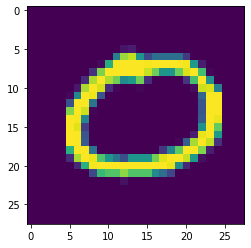

In [75]:
# Select an image from the test set and its corresponding true label
image = x_test[69]
label = y_test[69]
plt.imshow(image)

# Add a batch dimension to the input image
image = np.expand_dims(image, axis=0)


**To do**: Fast Gradient Sign Method
https://pyimagesearch.com/2021/03/01/adversarial-attacks-with-fgsm-fast-gradient-sign-method/

In [76]:

# Compute the gradient of the loss with respect to the input image
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
image_tensor = tf.convert_to_tensor(image)
with tf.GradientTape() as tape:
    tape.watch(image_tensor)
    prediction = model(image_tensor)
    loss = loss_object(label, prediction)
gradient = tape.gradient(loss, image_tensor)



Original CNN prediction: tf.Tensor([0], shape=(1,), dtype=int64)
Adversarial CNN prediction: tf.Tensor([0], shape=(1,), dtype=int64)
Original FCN prediction: tf.Tensor([0], shape=(1,), dtype=int64)
Adversarial FCN prediction: tf.Tensor([6], shape=(1,), dtype=int64)


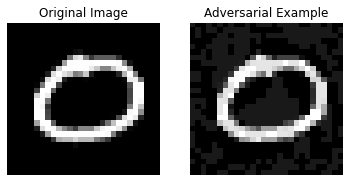

In [77]:



# Generate an adversarial example using FGSM
epsilon = 0.1
signed_grad = tf.sign(gradient)
adversarial_image = image + epsilon * signed_grad
adversarial_image = tf.clip_by_value(adversarial_image, clip_value_min=0.0, clip_value_max=1.0)

# Evaluate the model on the original image and the adversarial example
original_prediction = model_CNN(image)
adversarial_prediction = model_CNN(adversarial_image)

print('Original CNN prediction:', tf.argmax(original_prediction, axis=1))
print('Adversarial CNN prediction:', tf.argmax(adversarial_prediction, axis=1))
print('Original FCN prediction:', tf.argmax( model_FC(image), axis=1))
print('Adversarial FCN prediction:', tf.argmax(model_FC(adversarial_image), axis=1))

# Show the original image and the adversarial example
plt.subplot(1,2,1)
plt.imshow(image[0].squeeze(), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(adversarial_image.numpy().squeeze(), cmap='gray')
plt.title('Adversarial Example')
plt.axis('off')
plt.show()

In [78]:
test_loss, test_acc = model_CNN.evaluate(x_test, y_test)
print(f'CNN Test accuracy: {test_acc:.4f}')

test_loss, test_acc = model_FC.evaluate(x_test, y_test)
print(f'FC Test accuracy: {test_acc:.4f}')

313/313 [==============================] - 1s 4ms/step - loss: 0.0521 - accuracy: 0.9828
CNN Test accuracy: 0.9828
313/313 [==============================] - 1s 2ms/step - loss: 0.0915 - accuracy: 0.9709
FC Test accuracy: 0.9709


In [80]:
# Generate an adversarial dataset using FGSM

def generate_adversarial_examples(x_test, y_test, model, epsilon):
    # Create a copy of x_test
    x_adv = tf.identity(x_test)

    # Loop over all the examples in x_test
    for i in range(len(x_test)):
        image = tf.expand_dims(x_test[i], axis=0)
        label = tf.expand_dims(y_test[i], axis=0)

        # Compute the gradient of the loss with respect to the input image
        loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        image_tensor = tf.convert_to_tensor(image)
        with tf.GradientTape() as tape:
            tape.watch(image_tensor)
            prediction = model(image_tensor)
            loss = loss_object(label, prediction)
        gradient = tape.gradient(loss, image_tensor)

        # Generate an adversarial example using FGSM
        signed_grad = tf.sign(gradient)
        adversarial_image = image + epsilon * signed_grad
        adversarial_image = tf.clip_by_value(adversarial_image, clip_value_min=0.0, clip_value_max=1.0)

        # Update the adversarial example in x_adv
        indices = tf.constant([[i]])
        x_adv = tf.tensor_scatter_nd_update(x_adv, indices, adversarial_image)

    return x_adv

epsilon = 0.1
x_adv_cnn = generate_adversarial_examples(x_test, y_test, model_CNN, epsilon)
x_adv_fc = generate_adversarial_examples(x_test, y_test, model_FC, epsilon)



In [81]:
# Evaluate the model on the adversarial dataset
adv_loss, adv_acc = model_CNN.evaluate(x_adv_cnn, y_test, verbose=0)
print(f'CNN Adversarial accuracy: {adv_acc:.4f}')

adv_loss, adv_acc = model_FC.evaluate(x_adv_fc, y_test, verbose=0)
print(f'FC Adversarial accuracy: {adv_acc:.4f}')

CNN Adversarial accuracy: 0.4684
FC Adversarial accuracy: 0.0828


CNN Adversarial accuracy: 0.5155
FC Adversarial accuracy: 0.1312

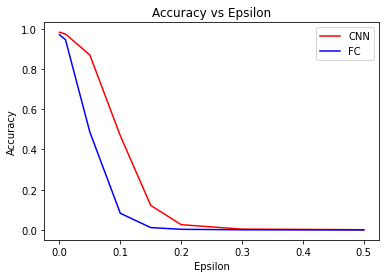

In [82]:
import matplotlib.pyplot as plt

epsilons = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5]
adv_acc_cnn = []
adv_acc_fc = []

for epsilon in epsilons:
    x_adv_cnn = generate_adversarial_examples(x_test, y_test, model_CNN, epsilon)
    x_adv_fc = generate_adversarial_examples(x_test, y_test, model_FC, epsilon)

    _, adv_acc = model_CNN.evaluate(x_adv_cnn, y_test, verbose=0)
    adv_acc_cnn.append(adv_acc)

    _, adv_acc = model_FC.evaluate(x_adv_fc, y_test, verbose=0)
    adv_acc_fc.append(adv_acc)

plt.plot(epsilons, adv_acc_cnn, 'r-', label='CNN')
plt.plot(epsilons, adv_acc_fc, 'b-', label='FC')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epsilon')
plt.legend()
plt.show()


***To do: ??***

In [92]:
model_CNN.summary()
model_FC.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 5408)              0         
                                                                 
 dense_11 (Dense)            (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
 Layer (type)               

In [98]:
from tqdm import tqdm

def generate_adversarial_examples(x_test, y_test, model, epsilon, num_steps, step_size):
    # Create a copy of x_test
    x_adv = tf.identity(x_test)

    # Loop over all the examples in x_test
    for i in tqdm(range(len(x_test))):
        image = tf.expand_dims(x_test[i], axis=0)
        label = tf.expand_dims(y_test[i], axis=0)

        # Generate an adversarial example using PGD
        adversarial_image = tf.identity(image)
        for j in range(num_steps):
            # Compute the gradient of the loss with respect to the input image
            loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
            image_tensor = tf.convert_to_tensor(adversarial_image)
            with tf.GradientTape() as tape:
                tape.watch(image_tensor)
                prediction = model(image_tensor)
                loss = loss_object(label, prediction)
            gradient = tape.gradient(loss, image_tensor)

            # Generate a perturbation using the gradient
            signed_grad = tf.sign(gradient)
            perturbation = step_size * signed_grad

            # Clip the perturbation to ensure it stays within the epsilon ball
            adversarial_image = tf.clip_by_value(adversarial_image + perturbation, clip_value_min=image - epsilon, clip_value_max=image + epsilon)
            adversarial_image = tf.clip_by_value(adversarial_image, clip_value_min=0.0, clip_value_max=1.0)

        # Update the adversarial example in x_adv
        indices = tf.constant([[i]])
        x_adv = tf.tensor_scatter_nd_update(x_adv, indices, adversarial_image)

    return x_adv

epsilon = 0.1
num_steps = 10
step_size = 0.01
x_adv_cnn = generate_adversarial_examples(x_test, y_test, model_CNN, epsilon, num_steps, step_size)
x_adv_fc = generate_adversarial_examples(x_test, y_test, model_FC, epsilon, num_steps, step_size)


100%|██████████| 10000/10000 [19:07<00:00,  8.72it/s]


In [95]:
x_adv_cnn = generate_adversarial_examples(x_test[:5], y_test[:5], model_CNN, epsilon, num_steps, step_size)


In [96]:
adv_loss, adv_acc = model_CNN.evaluate(x_adv_cnn, y_test[:5], verbose=0)

In [97]:
print(f'CNN Adversarial accuracy: {adv_acc:.4f}')

CNN Adversarial accuracy: 0.0000


In [99]:
# Evaluate the model on the adversarial dataset
adv_loss, adv_acc = model_CNN.evaluate(x_adv_cnn, y_test, verbose=0)
print(f'CNN Adversarial accuracy: {adv_acc:.4f}')

adv_loss, adv_acc = model_FC.evaluate(x_adv_fc, y_test, verbose=0)
print(f'FC Adversarial accuracy: {adv_acc:.4f}')

CNN Adversarial accuracy: 0.1238
FC Adversarial accuracy: 0.0482


### Shift Invariance

Shift invariance for convolutional neural networks (CNNs) means that the network's response is unchanged when the input is shifted in any direction by a fixed amount. This property is desirable in image recognition tasks where objects can appear at different locations in an image.
 Let $f(x)$ be the input image and $g(x)$ be a convolutional filter. The output of the convolution operation is given by:

$(f \ast g)(x)=\int f(y)g(x−y)dy$

where $\ast$ denotes convolution and $y$ is the spatial variable. Shift invariance means that if we shift the input image by a fixed amount $t$, the output of the convolution operation is also shifted by $t$:

$(f \ast g)(x−t) = \int f(y)g(x−y−t)dy =(f \ast g)(x) \ast h(t) $

where $h(t)$ is the impulse response of the filter, which is the filter's response to a unit impulse. This property allows us to use the same set of filters to extract features from an image regardless of its location in the image.

In [85]:

# Shift the test set by random amounts and evaluate the models
shift_range = 4
shifted_images = []
shifted_labels = []
for i in range(len(x_test)):
    dx, dy = np.random.randint(-shift_range, shift_range+1, size=2)
    shifted_image = np.roll(x_test[i], (dx, dy), axis=(0, 1))
    shifted_images.append(shifted_image)
    shifted_labels.append(y_test[i])
shifted_images = np.array(shifted_images)
shifted_labels = np.array(shifted_labels)



In [86]:
acc_cnn_shifted = model_CNN.evaluate(shifted_images, shifted_labels, verbose=0)[1]
acc_fc_shifted = model_FC.evaluate(shifted_images, shifted_labels, verbose=0)[1]

print('Shifted test set accuracy - CNN:', acc_cnn_shifted)
print('Shifted test set accuracy - FC:', acc_fc_shifted)

Shifted test set accuracy - CNN: 0.5658000111579895
Shifted test set accuracy - FC: 0.42649999260902405


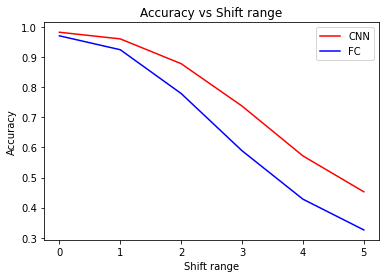

In [89]:
shift_acc_cnn = []
shift_acc_fc = []

for shift_range in range(6):
    shifted_images = []
    shifted_labels = []
    for i in range(len(x_test)):
        dx, dy = np.random.randint(-shift_range, shift_range+1, size=2)
        shifted_image = np.roll(x_test[i], (dx, dy), axis=(0, 1))
        shifted_images.append(shifted_image)
        shifted_labels.append(y_test[i])
    shifted_images = np.array(shifted_images)
    shifted_labels = np.array(shifted_labels)
    acc_cnn_shifted =[1]
    acc_fc_shifted =[1]

    _, shift_acc = model_CNN.evaluate(shifted_images, shifted_labels, verbose=0)
    shift_acc_cnn.append(shift_acc)

    _, shift_acc =  model_FC.evaluate(shifted_images, shifted_labels, verbose=0)
    shift_acc_fc.append(shift_acc)

plt.plot( range(6), shift_acc_cnn, 'r-', label='CNN')
plt.plot( range(6), shift_acc_fc, 'b-', label='FC')
plt.xlabel('Shift range')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Shift range')
plt.legend()
plt.show()

In [90]:
def generate_adversarial_examples(x_test, y_test, model, epsilon, iterations, alpha):
    """DNN"""

ValueError: Shapes (1,) and (1, 10) are incompatible

In [91]:


x_adv_cnn = generate_adversarial_examples(x_test, y_test_onehot, model_CNN, epsilon, iterations, alpha)
x_adv_fc = generate_adversarial_examples(x_test, y_test_onehot, model_FC, epsilon, iterations, alpha)



https://towardsdatascience.com/know-your-enemy-7f7c5038bdf3

https://pyimagesearch.com/2021/03/01/adversarial-attacks-with-fgsm-fast-gradient-sign-method/

1. FGSM (Fast Gradient Sign Method):
FGSM is a one-step attack algorithm that perturbs the input data using the sign of the gradient of the loss function with respect to the input.
It computes the perturbation by taking a single step in the direction of the gradient sign multiplied by a small epsilon value.
FGSM is a fast and computationally efficient method for generating adversarial examples.
However, the generated adversarial examples may not be as effective in terms of fooling the model compared to more sophisticated attack algorithms.

2. PGD (Projected Gradient Descent):
PGD is an iterative attack algorithm that performs multiple steps of gradient updates to find effective perturbations.
It starts with an initial perturbation and performs iterative updates by computing the gradient of the loss function with respect to the input and taking steps in the direction of the gradient.
The perturbation is projected onto a feasible region (such as an epsilon ball) to ensure it stays within certain constraints.
PGD explores a larger area in the input space and is more effective in finding small perturbations that can lead to misclassification.
PGD is computationally more expensive compared to FGSM due to the iterative nature of the algorithm.

In [ ]:
    FGSM (Fast Gradient Sign Method):
FGSM is a fast and computationally efficient adversarial attack method.
It perturbs the input data by taking a small step in the direction of the sign of the gradient of the loss function with respect to the input.
The objective of FGSM is to maximize the loss function to force misclassification or create adversarial examples.

PGD (Projected Gradient Descent):
PGD is an iterative optimization-based attack method that performs multiple steps of gradient descent.
It starts with a random or perturbed input and applies small incremental updates in the direction that maximizes the loss function.
At each step, the perturbed input is projected back into a valid range to ensure it remains within a specified epsilon ball (bounded perturbation).
PGD aims to find the perturbation that maximizes the loss function while staying within the defined constraints.

Deepfool with Decoupled Direction and Norm:
    Deepfool is an iterative attack method that aims to find the smallest perturbation required to change the classification of an input.
    It calculates the minimal adversarial perturbation by linearizing the decision boundary and iteratively updating the input towards it.
    Deepfool with Decoupled Direction and Norm (DDN) extends Deepfool by decoupling the direction and norm of the perturbation.
    DDN uses an iterative optimization process to find the minimal perturbation in a decoupled manner, considering both the direction and the norm of the perturbation separately.

In [ ]:
, the CNN model (simple_Conv_2D) uses circular padding (padding_mode='circular')

In [15]:
# File tree
from pathlib import Path

# prefix components:
space =  '    '
branch = '│   '
# pointers:
tee =    '├── '
last =   '└── '

def tree(dir_path: Path, prefix: str=''):
    """A recursive generator, given a directory Path object
    will yield a visual tree structure line by line
    with each line prefixed by the same characters
    """
    contents = list(dir_path.iterdir())
    # contents each get pointers that are ├── with a final └── :
    pointers = [tee] * (len(contents) - 1) + [last]
    for pointer, path in zip(pointers, contents):
        yield prefix + pointer + path.name
        if path.is_dir(): # extend the prefix and recurse:
            extension = branch if pointer == tee else space
            # i.e. space because last, └── , above so no more |
            yield from tree(path, prefix=prefix+extension)
startpath = r"C:\Users\anass\Desktop\TUM\Courses\Practical\Gitlab"
str_=""
for line in tree(Path(startpath)):
    print(line)

├── .ignore
├── .ipynb_checkpoints
│   └── Shift_Invariance_Can_Reduce_Adversarial_Robustness-checkpoint.ipynb
├── 2
├── can-reduce-adversarial-robustness.pdf
├── data
│   ├── adversarial_data_2
│   │   ├── 2_simple_Conv_10_512_ProjectedGradientDescentTensorFlowV2_0.05_test.npz
│   │   ├── 2_simple_Conv_10_512_ProjectedGradientDescentTensorFlowV2_0.05_train.npz
│   │   ├── 2_simple_Conv_10_512_ProjectedGradientDescentTensorFlowV2_0.15_test.npz
│   │   ├── 2_simple_Conv_10_512_ProjectedGradientDescentTensorFlowV2_0.15_train.npz
│   │   ├── 2_simple_Conv_10_512_ProjectedGradientDescentTensorFlowV2_0.1_test.npz
│   │   ├── 2_simple_Conv_10_512_ProjectedGradientDescentTensorFlowV2_0.1_train.npz
│   │   ├── 2_simple_Conv_10_512_ProjectedGradientDescentTensorFlowV2_0.25_test.npz
│   │   ├── 2_simple_Conv_10_512_ProjectedGradientDescentTensorFlowV2_0.25_train.npz
│   │   ├── 2_simple_Conv_10_512_ProjectedGradientDescentTensorFlowV2_0.2_test.npz
│   │   ├── 2_simple_Conv_10_512_ProjectedGradie

In [4]:
str(tree(Path(startpath)))

'<generator object tree at 0x0000019A7A307840>'

In [14]:
str_

'├── .ignore/n├── .ipynb_checkpoints/n│   └── Shift_Invariance_Can_Reduce_Adversarial_Robustness-checkpoint.ipynb/n├── 2/n├── can-reduce-adversarial-robustness.pdf/n├── data/n│   ├── adversarial_data_2/n│   │   ├── 2_simple_Conv_10_512_ProjectedGradientDescentTensorFlowV2_0.05_test.npz/n│   │   ├── 2_simple_Conv_10_512_ProjectedGradientDescentTensorFlowV2_0.05_train.npz/n│   │   ├── 2_simple_Conv_10_512_ProjectedGradientDescentTensorFlowV2_0.15_test.npz/n│   │   ├── 2_simple_Conv_10_512_ProjectedGradientDescentTensorFlowV2_0.15_train.npz/n│   │   ├── 2_simple_Conv_10_512_ProjectedGradientDescentTensorFlowV2_0.1_test.npz/n│   │   ├── 2_simple_Conv_10_512_ProjectedGradientDescentTensorFlowV2_0.1_train.npz/n│   │   ├── 2_simple_Conv_10_512_ProjectedGradientDescentTensorFlowV2_0.25_test.npz/n│   │   ├── 2_simple_Conv_10_512_ProjectedGradientDescentTensorFlowV2_0.25_train.npz/n│   │   ├── 2_simple_Conv_10_512_ProjectedGradientDescentTensorFlowV2_0.2_test.npz/n│   │   ├── 2_simple_Conv_10_51